### Loading Data

In [1]:
import numpy as np
import pandas as pd

DIR_PATH = "/kaggle/input/covid-segmentation/"
TRAIN_X_FILE = "images_medseg.npy"
TRAIN_Y_FILE = "masks_medseg.npy"

imgs_medseg = np.load(DIR_PATH+TRAIN_X_FILE).astype(np.float32)
msks_medseg = np.load(DIR_PATH+TRAIN_Y_FILE).astype(np.float32)

### Visualise the Images

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# plt.style.use("dark_background")

def visualize(image_batch, mask_batch=None, pred_batch=None, num_samples=8):
    num_classes = mask_batch.shape[-1] if mask_batch is not None else 0
    fix, ax = plt.subplots(num_classes + 1, num_samples, figsize=(num_samples * 2, (num_classes + 1) * 2))
    for i in range(num_samples):
        ax_image = ax[0, i] if num_classes > 0 else ax[i]
        ax_image.imshow(image_batch[i,:,:,0], cmap="Greys")
        ax_image.set_xticks([]) 
        ax_image.set_yticks([])
        
        if mask_batch is not None:
            for j in range(num_classes):
                if pred_batch is None:
                    mask_to_show = mask_batch[i,:,:,j]
                else:
                    mask_to_show = np.zeros(shape=(*mask_batch.shape[1:-1], 3)) 
                    mask_to_show[..., 0] = pred_batch[i,:,:,j] > 0.5
                    mask_to_show[..., 1] = mask_batch[i,:,:,j]
                ax[j + 1, i].imshow(mask_to_show, vmin=0, vmax=1)
                ax[j + 1, i].set_xticks([]) 
                ax[j + 1, i].set_yticks([]) 

    plt.tight_layout()
    plt.show()

**Description**
1. Actual Input
2. Mask for Ground Glass class
3. Mask for Consolidation class
4. Mask for Lungs Other class
5. Mask for Background Class

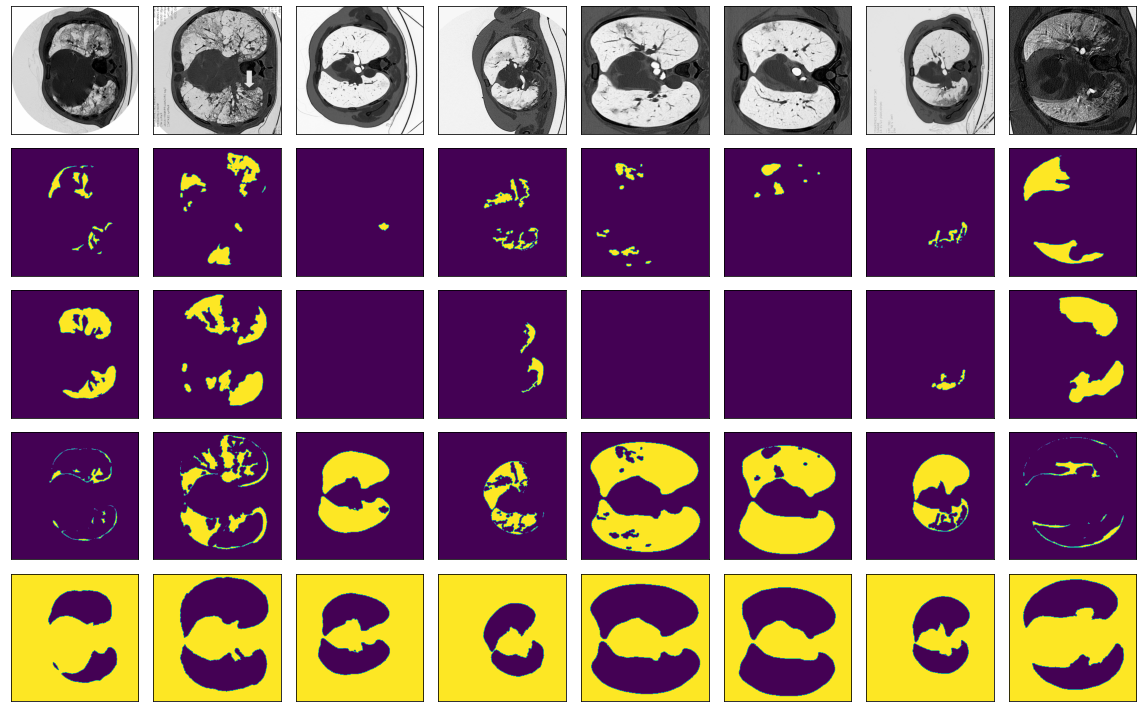

In [3]:
visualize(imgs_medseg, msks_medseg)

### Pixel Value Distribution Before Normalization

In [5]:
def plot_hists(images):
    plt.hist(images.ravel(), bins=100, density=True, color='b', alpha=1)

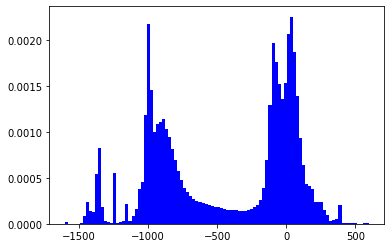

In [6]:
plot_hists(imgs_medseg)

### Normalizing Image Pixels

In [7]:
def normalize_img(img):
    img = img.astype("float32")
    img[img > 500] = 500
    img[img < -1500] = -1500
    min_perc, max_perc = np.percentile(img, 5), np.percentile(img, 95)
    img_valid = img[(img > min_perc) & (img < max_perc)]
    mean, std = img_valid.mean(), img_valid.std()
    img = (img-mean)/std
    return img

### Normalized Distribution of Pixels

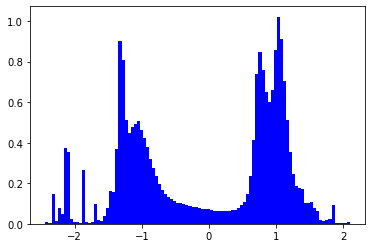

In [8]:
imgs_medseg = normalize_img(imgs_medseg)
plot_hists(imgs_medseg)

### Split training and validation data

In [9]:
from sklearn.model_selection import train_test_split
train_x, val_x, train_y, val_y = train_test_split(imgs_medseg, msks_medseg, test_size=0.1, random_state=42)

### Building The UNET Architecture

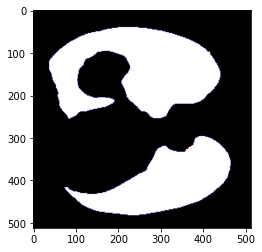

In [10]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
imgplot = plt.imshow(val_y[3])
plt.show()

In [11]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model

def convolution(input, num_filters):
  x = Conv2D(num_filters, 3, padding="same")(input)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  x = Conv2D(num_filters, 3, padding="same")(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)
  return x

def downsample(input, num_filters):
  x = convolution(input, num_filters)
  p = MaxPool2D((2,2))(x)
  return x, p

def upsample(input, skip_connections, num_filters):
  x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
  x = Concatenate()([x, skip_connections])
  x = convolution(x, num_filters)
  return x

def build_unet(input_shape):
  inputs = Input(input_shape)
  
  sc1, p1 = downsample(inputs, 64)
  sc2, p2 = downsample(p1, 128)
  sc3, p3 = downsample(p2, 256)
  sc4, p4 = downsample(p3, 512)

  b1 = convolution(p4, 1024)

  d1 = upsample(b1, sc4, 512)
  d2 = upsample(d1, sc3, 256)
  d3 = upsample(d2, sc2, 128)
  d4 = upsample(d3, sc1, 64)

  outputs = Conv2D(4,(1,1),padding="same",activation="softmax")(d4)

  model = Model(inputs, outputs, name="U-Net")
  return model

### IoU Metric Definition

In [12]:
def iou(true_y, pred_y):
    def f(true_y, pred_y):
        intersection = (true_y * pred_y).sum()
        union = true_y.sum() + pred_y.sum() - intersection
        x = (intersection)/(union)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [true_y, pred_y], tf.float32)

### Building Model

In [13]:
unet = build_unet(imgs_medseg.shape[1:])
unet.compile(loss="binary_crossentropy", optimizer="adam", metrics=["acc", iou])
results = unet.fit(train_x, train_y, validation_data=(val_x, val_y), epochs=100, batch_size=1, verbose=1)

Epoch 1/100
90/90 [==============================] - 23s 171ms/step - loss: 0.4401 - acc: 0.6488 - iou: 0.3751 - val_loss: 322.4522 - val_acc: 0.0395 - val_iou: 0.0205
Epoch 2/100
90/90 [==============================] - 14s 159ms/step - loss: 0.2610 - acc: 0.7901 - iou: 0.5772 - val_loss: 10.5857 - val_acc: 0.3913 - val_iou: 0.2244
Epoch 3/100
90/90 [==============================] - 14s 160ms/step - loss: 0.2093 - acc: 0.8465 - iou: 0.6695 - val_loss: 2.8727 - val_acc: 0.0427 - val_iou: 0.0348
Epoch 4/100
90/90 [==============================] - 14s 160ms/step - loss: 0.2091 - acc: 0.8176 - iou: 0.6563 - val_loss: 0.4670 - val_acc: 0.7711 - val_iou: 0.5934
Epoch 5/100
90/90 [==============================] - 14s 159ms/step - loss: 0.1553 - acc: 0.8815 - iou: 0.7586 - val_loss: 1.6457 - val_acc: 0.4392 - val_iou: 0.2613
Epoch 6/100
90/90 [==============================] - 14s 160ms/step - loss: 0.1633 - acc: 0.8691 - iou: 0.7376 - val_loss: 0.5356 - val_acc: 0.6515 - val_iou: 0.4383
E

### Training Analytics

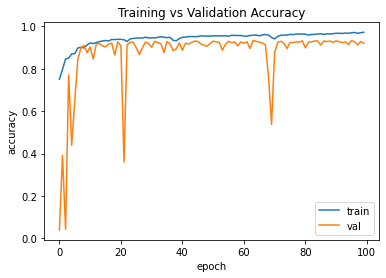

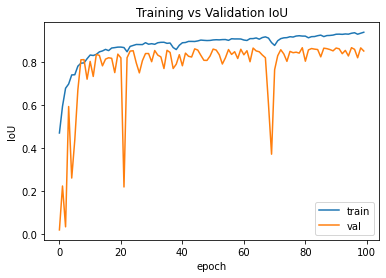

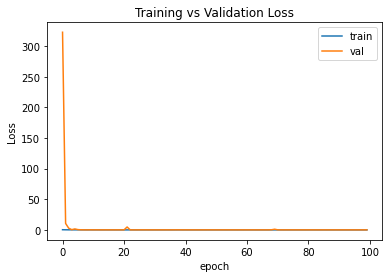

In [14]:
plt.figure(0)
plt.plot(results.history["acc"])
plt.plot(results.history["val_acc"])
plt.title("Training vs Validation Accuracy")

plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(["train", "val"])
plt.show()

plt.figure(1)
plt.plot(results.history["iou"])
plt.plot(results.history["val_iou"])
plt.title("Training vs Validation IoU")

plt.xlabel("epoch")
plt.ylabel("IoU")
plt.legend(["train", "val"])
plt.show()

plt.figure(1)
plt.plot(results.history["loss"])
plt.plot(results.history["val_loss"])
plt.title("Training vs Validation Loss")

plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend(["train", "val"])
plt.show()

### Segmented Output for Ground Glass

(10, 512, 512, 4)


<Figure size 432x288 with 0 Axes>

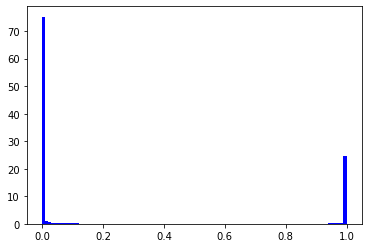

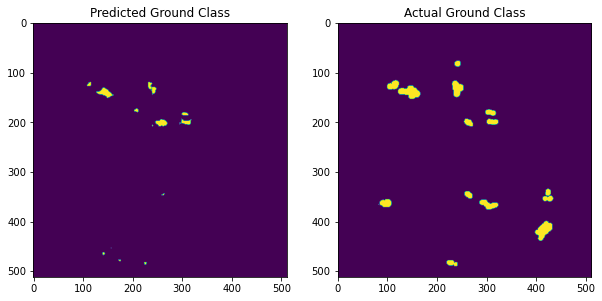

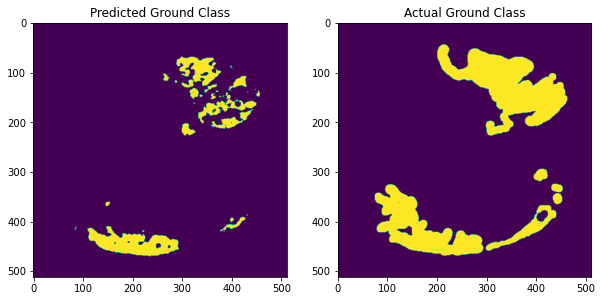

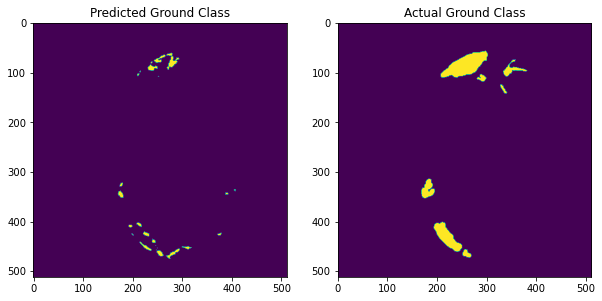

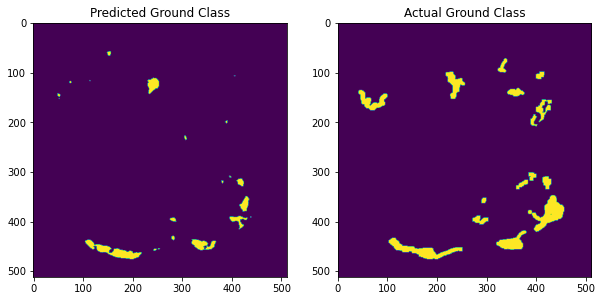

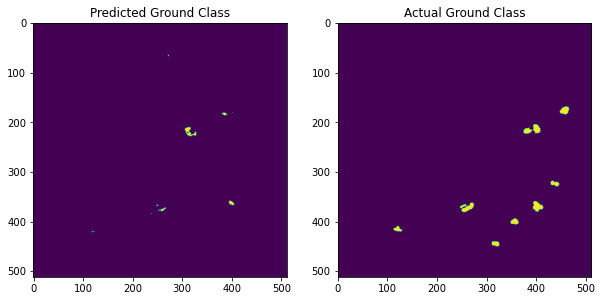

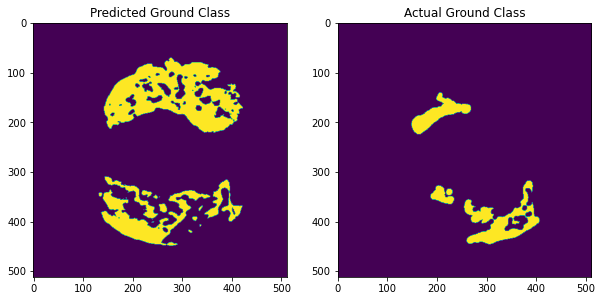

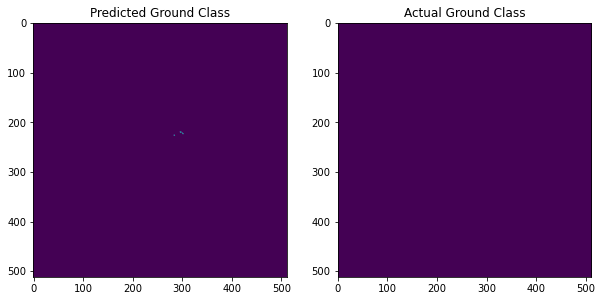

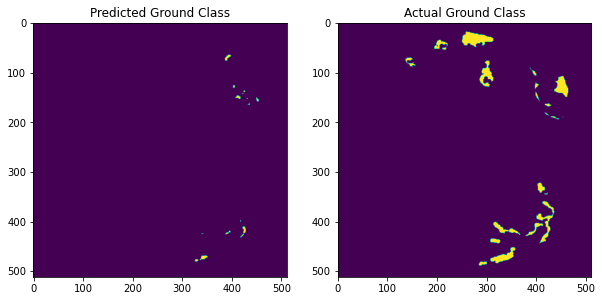

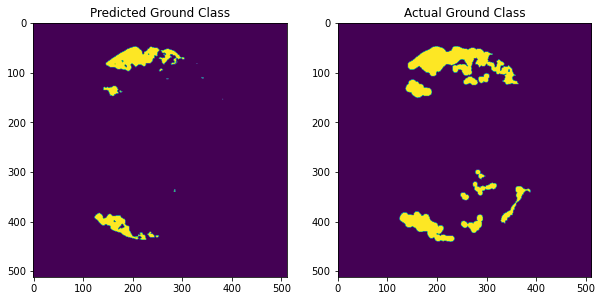

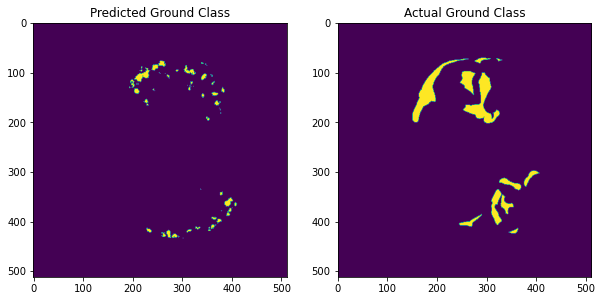

In [15]:
pred_y = unet.predict(val_x)
plot_hists(pred_y)

def filter_pixels(img):
    for i in range(img.shape[0]):
        for j in range(img.shape[3]):
            for k in range(img.shape[1]):
                for l in range(img.shape[2]):
                    img[i,k,l,j] = 1 if (img[i,k,l,j] > 0.5) else 0;
    return img

pred_y = filter_pixels(pred_y)
plot_hists(pred_y)

print(pred_y.shape)
for i in range(0, 10):
    plt.figure(i)
    fig, ax = plt.subplots(1,2, figsize=(10,10))
    ax[0].imshow(pred_y[i,:,:,0])
    ax[0].title.set_text("Predicted Ground Class")
    ax[1].imshow(val_y[i,:,:,0])
    ax[1].title.set_text("Actual Ground Class")

In [ ]:
t_y_f, p_y_f = train_y.flatten(), pred_y.flatten()

In [ ]:
import seaborn as sns

FP = len(np.where(p_y_f - t_y_f  == -1)[0])
FN = len(np.where(p_y_f - t_y_f  == 1)[0])
TP = len(np.where(p_y_f + t_y_f ==2)[0])
TN = len(np.where(p_y_f + t_y_f == 0)[0])
cmat = [[TP, FN], [FP, TN]]

plt.figure(figsize = (6,6))
sns.heatmap(cmat/np.sum(cmat), cmap="Reds", annot=True, fmt = '.2%', square=1,   linewidth=2.)
plt.xlabel("predictions")
plt.ylabel("real values")
plt.show()
